In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
import xgboost
import lightgbm
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder,StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,GridSearchCV, KFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import ElasticNet,LinearRegression, LassoCV, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error , mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import RFE
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/sample.csv.csv
/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/train.csv
/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/test.csv


# **Data Loading**

In [2]:
test= pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/test.csv')
train= pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/train.csv')
sample= pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/sample.csv.csv')

In [3]:
print(train.shape)
print(test.shape)
print(sample.shape)

(175000, 17)
(50000, 16)
(1000, 2)


In [4]:
train.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175000 entries, 0 to 174999
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               175000 non-null  int64  
 1   tpep_pickup_datetime   175000 non-null  object 
 2   tpep_dropoff_datetime  175000 non-null  object 
 3   passenger_count        168923 non-null  float64
 4   trip_distance          175000 non-null  float64
 5   RatecodeID             168923 non-null  float64
 6   store_and_fwd_flag     168923 non-null  object 
 7   PULocationID           175000 non-null  int64  
 8   DOLocationID           175000 non-null  int64  
 9   payment_type           175000 non-null  object 
 10  extra                  175000 non-null  float64
 11  tip_amount             175000 non-null  float64
 12  tolls_amount           175000 non-null  float64
 13  improvement_surcharge  175000 non-null  float64
 14  total_amount           175000 non-nu

In [5]:
train.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,175000.000000,168923.000000,175000.000000,168923.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,168923.000000,168923.000000
mean,0.728377,1.357678,5.145930,1.518307,132.710349,132.701429,1.932143,6.127497,0.646816,0.979689,29.633901,2.246971,0.158825
std,0.445606,0.891283,394.971052,6.514678,76.148799,76.192493,1.948497,4.610834,2.328274,0.198775,25.425206,0.819216,0.511968
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,-7.500000,0.000079,-29.300000,-1.000000,-576.750000,-2.500000,-1.750000
25%,0.000000,1.000000,1.080000,1.000000,67.000000,67.000000,0.000000,3.473321,0.000000,1.000000,16.300000,2.500000,0.000000
50%,1.000000,1.000000,1.840000,1.000000,133.000000,133.000000,1.000000,5.286217,0.000000,1.000000,21.450000,2.500000,0.000000
75%,1.000000,1.000000,3.610000,1.000000,199.000000,199.000000,2.500000,7.502746,0.000000,1.000000,31.800000,2.500000,0.000000
max,2.000000,9.000000,135182.060000,99.000000,264.000000,264.000000,11.750000,484.876151,80.000000,1.000000,587.250000,2.500000,1.750000


In [6]:
# train.head()

In [7]:
df= pd.DataFrame(train)
df.dtypes
d= pd.DataFrame(test)
# d

In [8]:
train.isnull().sum()

VendorID                    0
tpep_pickup_datetime        0
tpep_dropoff_datetime       0
passenger_count          6077
trip_distance               0
RatecodeID               6077
store_and_fwd_flag       6077
PULocationID                0
DOLocationID                0
payment_type                0
extra                       0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
total_amount                0
congestion_surcharge     6077
Airport_fee              6077
dtype: int64

In [9]:
'''
Splitting of dataset
'''
def dataset_split(df):
    X= df.drop('total_amount',axis=1)
    Y= df['total_amount']
    return(X,Y)
X,Y= dataset_split(df)

# **Feature Engineering**

**Feature Construction**

In [10]:
'''
Handling datetime features
'''
def datetime_features(X):
    X['tpep_pickup_datetime']= pd.to_datetime(X['tpep_pickup_datetime'])
    X['tpep_dropoff_datetime']= pd.to_datetime(X['tpep_dropoff_datetime'])
    duration_seconds= (X['tpep_dropoff_datetime']- X['tpep_pickup_datetime']).dt.total_seconds()
#     neg_values_mask= duration_seconds>=0
#     X= X[neg_values_mask] 
    X['duration']= abs(duration_seconds)
    X= X.drop(columns=['tpep_pickup_datetime','tpep_dropoff_datetime'],axis=1)
    return(X)
X= datetime_features(X)

In [11]:
X.shape

(175000, 15)

In [12]:
X.nunique()<10

VendorID                  True
passenger_count           True
trip_distance            False
RatecodeID                True
store_and_fwd_flag        True
PULocationID             False
DOLocationID             False
payment_type              True
extra                    False
tip_amount               False
tolls_amount             False
improvement_surcharge     True
congestion_surcharge      True
Airport_fee               True
duration                 False
dtype: bool

**Feature Transformation**

In [13]:
'''
Preprocessing
'''
def preprocessing(X):
    feature_names= X.columns
    ord_features = ['VendorID', 'passenger_count','congestion_surcharge','improvement_surcharge','RatecodeID','Airport_fee']
    encoded_values=['payment_type','store_and_fwd_flag']
    num_features = [x for x in feature_names if x not in ord_features and x not in encoded_values]
    # print(num_features)
    num_imputer = SimpleImputer(missing_values=np.nan, strategy='mean') 
    ord_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    cat_pipeline= Pipeline(steps=[('ord_imputer',ord_imputer),
                                 ('ohe', OneHotEncoder(drop='first'))])

    preprocessor = ColumnTransformer(
        transformers=[('num', ord_imputer,ord_features),
                      ('num_imputer', num_imputer,num_features),
                     ('cat_pipe',cat_pipeline,encoded_values)],
            remainder= 'passthrough')
    X_processed = preprocessor.fit_transform(X)
    transformed_num_feature_names = preprocessor.named_transformers_['num_imputer'].get_feature_names_out(num_features)
    transformed_cat_feature_names = preprocessor.named_transformers_['cat_pipe'].named_steps['ohe'].get_feature_names_out(encoded_values)
    transformed_cat_feature_names_= preprocessor.named_transformers_['num'].get_feature_names_out(ord_features)

    all_feature_names = list(transformed_cat_feature_names_)+list(transformed_num_feature_names) + list(transformed_cat_feature_names)  
    X_processed= pd.DataFrame(X_processed,columns= all_feature_names)
    return(X_processed)
X_processed = preprocessing(X)
# print(all_feature_names)

In [14]:
Y= pd.DataFrame(Y)
# X_processed

In [15]:
X_processed.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorID,175000.0,0.728377,0.445606,0.000000,0.000000,1.000000,1.000000,2.000000
passenger_count,175000.0,1.345257,0.878116,0.000000,1.000000,1.000000,1.000000,9.000000
congestion_surcharge,175000.0,2.255757,0.806199,-2.500000,2.500000,2.500000,2.500000,2.500000
improvement_surcharge,175000.0,0.979689,0.198775,-1.000000,1.000000,1.000000,1.000000,1.000000
RatecodeID,175000.0,1.500309,6.401268,1.000000,1.000000,1.000000,1.000000,99.000000
Airport_fee,175000.0,0.153310,0.503840,-1.750000,0.000000,0.000000,0.000000,1.750000
trip_distance,175000.0,5.145930,394.971052,0.000000,1.080000,1.840000,3.610000,135182.060000
PULocationID,175000.0,132.710349,76.148799,1.000000,67.000000,133.000000,199.000000,264.000000
DOLocationID,175000.0,132.701429,76.192493,1.000000,67.000000,133.000000,199.000000,264.000000
extra,175000.0,1.932143,1.948497,-7.500000,0.000000,1.000000,2.500000,11.750000


#  **EDA**

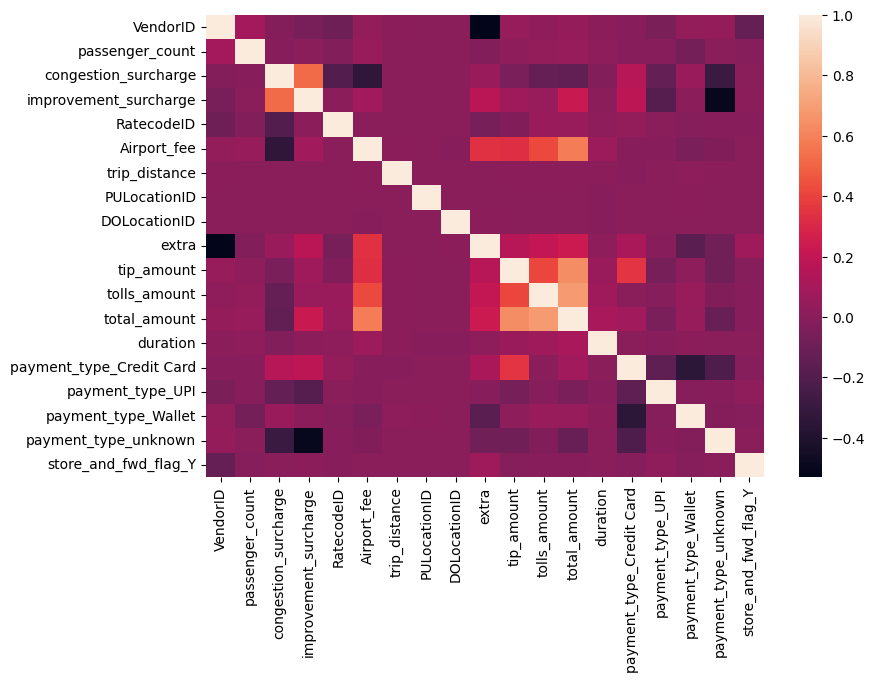

In [16]:
x = datetime_features(train)
x_dummy = preprocessing(x)
map = x_dummy.corr()
plt.figure(figsize=(9,6))
sns.heatmap(map)
plt.show()

In [17]:
# X_processed.columns

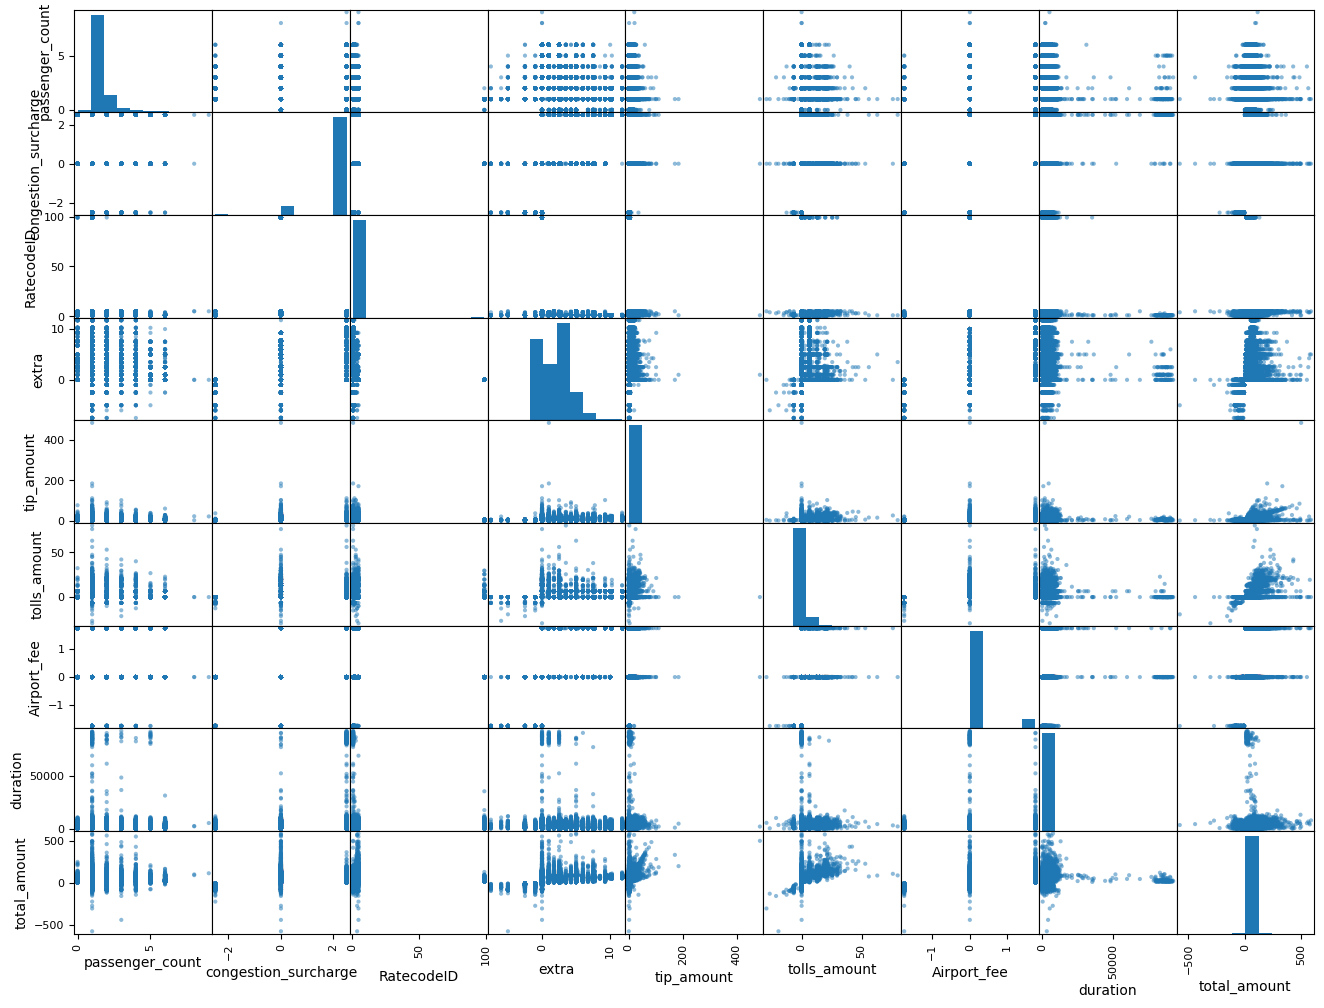

In [18]:
attributes= ['passenger_count', 'congestion_surcharge','RatecodeID','extra', 'tip_amount','tolls_amount', 'Airport_fee','duration','total_amount']
scatter_matrix(x_dummy[attributes],figsize=(16,12));

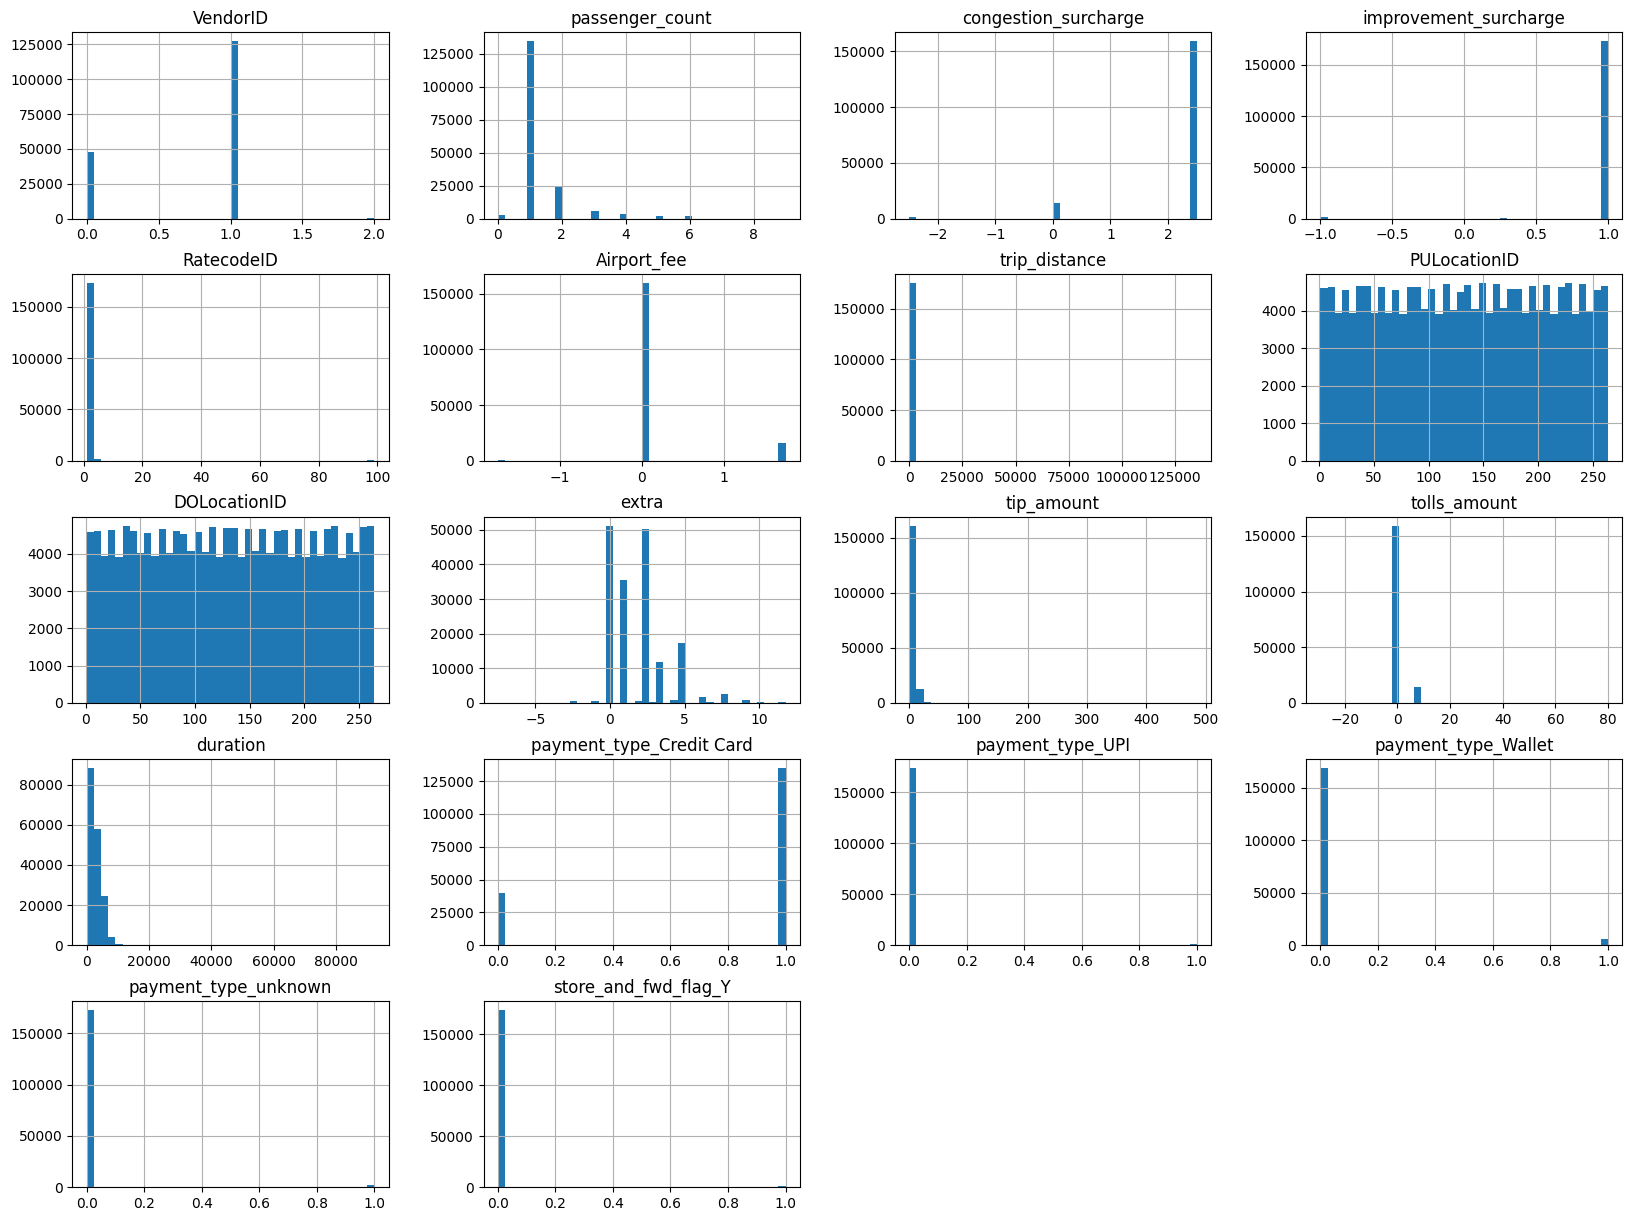

In [19]:
X_processed.hist(bins=40, figsize= (20,15));

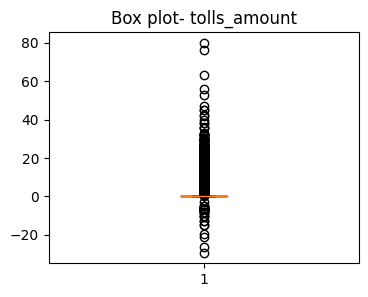

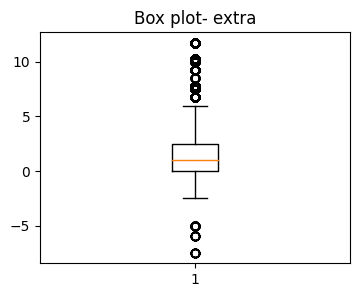

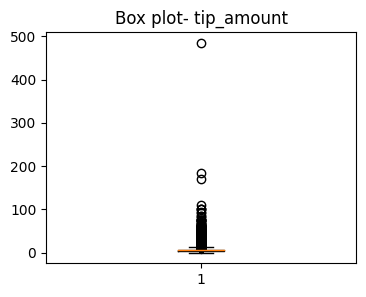

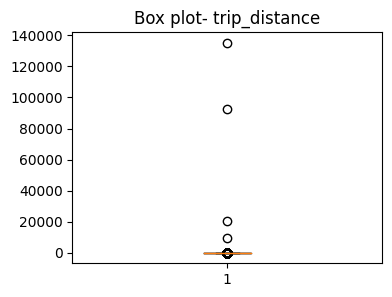

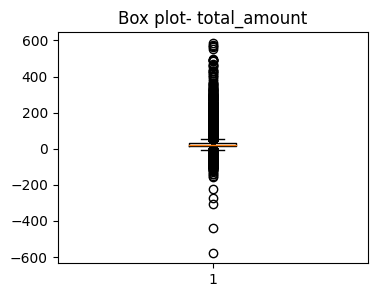

In [20]:
# for column in X_processed.columns:
columns= ['tolls_amount','extra','tip_amount','trip_distance','total_amount']
for column in columns:
    plt.figure(figsize=(4,3))
    plt.boxplot(x_dummy[column])
    plt.title(f"Box plot- {column}")

In [21]:
def eda(X_processed):
    col= ['tolls_amount','extra','congestion_surcharge','Airport_fee']
    X_processed[col]= abs(X_processed[col])
    return(X_processed)
X_processed= eda(X_processed)

 **Feature Selection**
____Dukh:(

In [22]:
# alpha= [0.001,0.01,0.1,1.0,5.0,10.0]
# lasso = LassoCV(alphas=alpha,cv=5)

# lasso.fit(X_train, Y_train)
# best_alpha= lasso.alpha_
# # Select non-zero coefficient features
# selected_features = np.where(lasso.coef_ != 0)[0]
# selected_feature_names = X_train.columns[selected_features]

# X_selected = X_train[selected_feature_names]
# X_selected

In [23]:
def features_drop(X):
#     'PULocationID','DOLocationID'
    columns= []
    X= X.drop(columns, axis=1)
    return X
X_processed= features_drop(X_processed)

**Outliers Handling**

In [24]:
'''
Z_score
'''
# def handle_outliers(col, X_processed):
#     a=  X_processed[col]
#     z_score = (a- np.mean(a))/np.std(a)
#     outliers= np.abs(z_score)>3
#     X_processed.drop(X_processed.index[outliers], inplace= True)

#     Y.drop(Y.index[outliers], inplace= True)
#     return(X_processed[col])
# columns= ['trip_distance','tolls_amount','extra','tip_amount']
# for col in columns:
#     X_processed[col] = handle_outliers(col, X_processed)
# X_processed.shape

'\nZ_score\n'

In [25]:
'''
IQR
'''
# def handle_outliers(col, X_processed):
#     a=  X_processed[col]
#     q1 = np.percentile(a, 25)
#     q3 = np.percentile(a, 75)
#     iqr = q3 - q1
#     threshold = 1.5 * iqr
#     outliers = np.where((a < q1 - threshold) | (a > q3 + threshold))
#     X_processed.drop(X_processed.index[outliers], inplace= True)

#     Y.drop(Y.index[outliers], inplace= True)
#     return(X_processed[col])
# columns= ['trip_distance','tolls_amount','extra','tip_amount']
# for col in columns:
#     X_processed[col] = handle_outliers(col, X_processed)
# X_processed.shape

'\nIQR\n'

In [26]:
'''
Capping
'''
# def handle_outliers(col, X_processed):
#     a=  X_processed[col]
#     q = np.percentile(a, 99)
#     outliers = np.where(a > q)[0]
#     X_processed.drop(X_processed.index[outliers], inplace= True)

#     Y.drop(Y.index[outliers], inplace= True)
#     return(X_processed[col])
# columns= ['trip_distance','tolls_amount','extra','tip_amount']
# for col in columns:
#     X_processed[col] = handle_outliers(col, X_processed)
# X_processed.shape

'\nCapping\n'

**Observation**

For handling outliers, I tried using z-scores, IQR, and capping by removing samples beyond the 99th percentile. However, this resulted in a decrease in accuracy. This suggests that either the outliers are important for the model, or the model can handle them on its own.

**Spliting of Train Set**

In [27]:
X_train,X_val,Y_train,Y_val= train_test_split(X_processed,Y,test_size=0.2,random_state=42)
print(X_train.shape)
print(Y_train.shape)

(140000, 18)
(140000, 1)


In [28]:
# X_train.nunique()

# **Testing Data**

In [29]:
Z = datetime_features(d)
X_test= preprocessing(Z)
X_test= eda(X_test)
X_test= features_drop(X_test)
X_test.shape

(50000, 18)

# **Model Training**

In [30]:
# ss = StandardScaler()
# X_train_scaled = ss.fit_transform(X_train)
# X_val_scaled = ss.fit_transform(X_val)
Y_val= np.ravel(Y_val)
Y_train= np.ravel(Y_train)

In [31]:
# ada= AdaBoostRegressor(random_state=42)
# ada.fit(X_train,Y_train)
# y_pred_sgd = ada.predict(X_val)
# score= r2_score(Y_val, y_pred_sgd)
# print(score)

In [32]:
# knr= KNeighborsRegressor(algorithm='ball_tree', n_neighbors= 3)
# knr.fit(X_train_scaled,Y_train)
# Y_pred= knr.predict(X_val_scaled)
# y_pred_knr = knr.predict(X_test)
# score= r2_score(Y_val, Y_pred)
# print(score)

In [33]:
# svr= SVR()
# svr.fit(X_train,Y_train)
# Y_pred= svr.predict(X_val)
# # y_pred= reg.predict(X_test)
# score= r2_score(Y_val, Y_pred)
# score
'''
Rejected. Since, SVR is not compatible with the samples below 10k.
'''

'\nRejected. Since, SVR is not compatible with the samples below 10k.\n'

In [34]:
# reg= LinearRegression()
# reg.fit(X_train,Y_train)
# Y_pred= reg.predict(X_val)
# y_pred= reg.predict(X_test)
# score= reg.score(X_val,Y_val)
# print(score)

**DummyRegressor**

In [35]:
# dummy_reg= DummyRegressor()
# dummy_reg.fit(X_train,Y_train)
# dummy_pred= dummy_reg.predict(X_val)
# score= r2_score(Y_val,dummy_pred)
# score

**MLPRegressor**

In [36]:
# param_grid= param_grid= {'hidden_layer_sizes':[(50,50,50),(50,100,50),(100,)],
#                         'alpha':[0.0001,0.001,0.01,0.1],
#                         'learning_rate':['adaptive','constant']}
# mlp_reg= MLPRegressor()
# grid_search= GridSearchCV(mlp_reg, param_grid= param_grid,cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train,Y_train)
# y_pred_= grid_search.predict(X_val)
# score= r2_score(Y_val, y_pred_)
# print(score)
# print(grid_search.best_params_)

In [37]:
# mlp_reg= MLPRegressor(alpha= 0.01,hidden_layer_sizes= (50, 50, 50),learning_rate ='constant', random_state=42)
# mlp_reg.fit(X_train,Y_train)
# y_pred = mlp_reg.predict(X_val)
# y_pred_mlp = mlp_reg.predict(X_test)
# score= r2_score(Y_val, y_pred)
# print(score)

**Random Forest Regressor**

In [38]:
# param_distributions= {'max_depth' :[9,10,11,20]
#              ,'ccp_alpha':[0.1, 0.01, 1]
#              ,'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4]}
# rfr= RandomForestRegressor()
# grid_search= RandomizedSearchCV(rfr, param_distributions = param_distributions,cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train,Y_train)
# y_pred_= grid_search.predict(X_val)
# score= r2_score(Y_val, y_pred_)
# print(grid_search.best_params_)
# print(score)

In [39]:
'''
RandomForestRegressor
'''
rfr= RandomForestRegressor(min_samples_split=10,min_samples_leaf= 2,max_depth= 20,ccp_alpha= 0.01, random_state=42)
rfr.fit(X_train,Y_train)
y_pred_rfr = rfr.predict(X_test)
y_pred= rfr.predict(X_val)
score= r2_score(Y_val,y_pred)
print(score)

0.9566535430895576


In [40]:
# param_grid= {'splitter':['best','random'],
#             'max_depth' :[9,10,11,20,19,18],'ccp_alpha':[0.1, 0.001,0.01],
#              'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4]}
# etr= ExtraTreeRegressor(random_state=42)
# grid_search= GridSearchCV(etr, param_grid= param_grid,cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train,Y_train)
# y_pred_= grid_search.predict(X_val)
# score= r2_score(Y_val, y_pred_)
# print(grid_search.best_params_)

In [41]:
# etr= ExtraTreeRegressor(ccp_alpha= 0.001,max_depth= 11,min_samples_leaf= 2,min_samples_split= 5,splitter= 'best',random_state=42)
# etr.fit(X_train,Y_train)
# y_pred_etr = etr.predict(X_test)
# y_pred= etr.predict(X_val)
# score= r2_score(Y_val,y_pred)
# print(score)

**Decision Tree Regressor**

In [42]:
# param_grid= {'criterion':['squared_error'], 'splitter':['best','random'],
#             'max_depth' :[9,10,11,20],'ccp_alpha':[0.1, 0.001, 1, 10],
#              'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4]}
# grid_search= GridSearchCV(DT, param_grid= param_grid,cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train,Y_train)
# y_pred_= grid_search.predict(X_val)
# score= r2_score(Y_val, y_pred_)
# print(grid_search.best_params_)

In [43]:
# '''
# DecisionTreeRegressor
# '''
# DT= DecisionTreeRegressor(ccp_alpha= 0.001, criterion= 'squared_error',
#                           max_depth= 11,min_samples_leaf=  1,
#                           min_samples_split= 10,splitter= 'best')
# DT.fit(X_train,Y_train)
# y_pred_= DT.predict(X_val)
# score= r2_score(Y_val, y_pred_)
# print(score)

In [44]:
# y_pred_dt= DT.predict(X_test)

**LightGBM**

In [45]:
# param_grid= {'learning_rate':[0.01,0.1,0.2],'n_estimators':[100,200,300],
#             'max_depth':[3,5,7,9,11,15], 'subsample':[0.8,0.9,1.0, 1.1]}
# lgbm_reg= LGBMRegressor()
# grid_search= GridSearchCV(lgbm_reg, param_grid= param_grid,cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train,Y_train)
# y_pred_= grid_search.predict(X_val)
# score= r2_score(Y_val, y_pred_)
# print(grid_search.best_params_)
# print(score)

In [46]:
# '''
# LightGBMRegressor
# '''
# lgbm_reg= LGBMRegressor(learning_rate= 0.1, n_estimators = 100, max_depth=7, subsample=0.8)
# lgbm_reg.fit(X_train,Y_train)
# lgbm_prediction= lgbm_reg.predict(X_test)
# y_pred_gbm= lgbm_reg.predict(X_val)
# score= r2_score(Y_val, y_pred_gbm)
# print(score)

**XGBRegressor**

In [47]:
# kfold= KFold(n_splits=5, shuffle=True, random_state=42)
# xg_reg= XGBRegressor()
# params={'max_depth':[3,6,7],
# 'learning_rate':[0.1, 0.3],
# 'early_stopping_rounds':[150],
# 'colsample_bytree':[0.2,0.4,0.7],
# 'subsample' : [0.8, 0.9],
# 'n_estimators':[9999],
# 'tree_method' :['hist']}
# grid_reg= GridSearchCV(estimator= xg_reg,param_grid=params, cv=kfold, scoring='neg_mean_squared_error' )
# eval_set= [(X_train, Y_train),(X_val, Y_val)]
# grid_reg.fit(X_train, Y_train, eval_set=eval_set, verbose=0)
# best_params= grid_reg.best_params_
# print(best_params)

In [48]:
# best_hyperparameters= {}
# best_cv_score= 0
# for max_depth in [3,6,7]:
#     for learning_rate in [0.1, 0.3]:
#         for colsample_bytree in [0.2,0.4,0.7]:
#             for subsample in [0.8, 0.9]:
#                 kf = KFold(n_splits=5, shuffle=True, random_state=42)
#                 best_iteration_xgb = []
#                 scores = []
#                 MODELS = []
#                 for i, (train_index, valid_index) in enumerate(kf.split(X_processed,Y)):
#                     X_train_fold= X_processed.iloc[train_index]
#                     Y_train_fold= Y.iloc[train_index]
#                     X_valid= X_processed.iloc[valid_index]
#                     Y_valid= Y.iloc[valid_index]
                    
#                     model = XGBRegressor( max_depth= max_depth, learning_rate= learning_rate, colsample_bytree= colsample_bytree, 
#                                          seed= 42, subsample= subsample, early_stopping_rounds= 150, n_estimators= 9999, tree_method= 'hist')
                    
#                     model.fit(X_train_fold , Y_train_fold ,eval_set=[(X_train_fold, Y_train_fold),(X_valid, Y_valid)],verbose=0 )
#                     MODELS.append( model )
#                     predictions = model.predict(X_valid)
#                     fold_score = r2_score(Y_valid,predictions)
#                     scores.append(fold_score)
#                 mean_score= np.mean(scores)  
#                 if mean_score > best_cv_score:
#                     best_cv_score= mean_score
#                     fold_importance_df = pd.DataFrame()
#                     fold_importance_df["feature"] = X_train.columns
#                     fold_importance_df["importance"] = model.feature_importances_
#                     best_hyperparameters= {'max_depth': max_depth, 'learning_rate': learning_rate, 'colsample_bytree': colsample_bytree, 'subsample': subsample}
#                     print(mean_score)
#                     print('Fold Feature Importance:')
#                     display(fold_importance_df.sort_values(by='importance', ascending= True).head(10))
#                 print(best_hyperparameters)
                
# print()
# print(f'Average Vaildation RMSLE Score:',best_cv_score)

In [49]:
# '''
# XGBRegressor
# '''
# xg_reg = XGBRegressor(max_depth= 7,learning_rate= 0.1,colsample_bytree= 0.7,subsample= 0.9,
#                       early_stopping_rounds= 150, n_estimators= 9999, tree_method= 'hist')
# xg_reg.fit(X_train,Y_train, eval_set=[(X_train, Y_train), (X_val, Y_val)],verbose=0)
# xg_prediction= xg_reg.predict(X_test)
# y_pred_xg= xg_reg.predict(X_val)
# score= r2_score(Y_val, y_pred_xg)
# print(score)

In [50]:
'''
Observation
'''

'\nObservation\n'

# **Submission**

In [51]:
submission = pd.DataFrame(columns=['ID','total_amount'])

submission['ID'] = [i for i in range(1, len(y_pred_rfr)+1)]
submission['total_amount'] = y_pred_rfr
submission.to_csv('submission.csv', index=False)
submission.shape

(50000, 2)